In [1]:
import random
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from deap import base, creator, tools

from matplotlib import pyplot as plt

In [2]:
dataset = pd.read_csv('dataset.csv', delimiter=';', low_memory='False')

In [3]:
#Drop columns that are not needed
dataset = dataset.drop(['user','gender','age','how_tall_in_meters','weight','body_mass_index'], axis=1)

In [4]:

#Centering
scaler = StandardScaler(with_mean=True, with_std=False)
dataset[['x1','y1','z1','x2','y2','z2','x3','y3','z3','x4','y4','z4']] = scaler.fit_transform(dataset[['x1','y1','z1','x2','y2','z2','x3','y3','z3','x4','y4','z4']])


In [5]:
#Getting the means
means = dataset.groupby('Class')[['x1','y1','z1','x2','y2','z2','x3','y3','z3','x4','y4','z4']].mean()


In [6]:
#Separating means for the sitting state and the other states
sitting_mean = means.T.pop('sitting').T
states_means = means.T.drop('sitting', axis=1).T

sitting_mean

x1    -0.486084
y1   -22.306565
z1    43.635725
x2    28.910872
y2    -3.106982
z2    87.851017
x3     5.975411
y3   -16.033985
z3    -1.506830
x4    35.909071
y4   -17.211905
z4    -2.330129
Name: sitting, dtype: float64

In [7]:
states_means

,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,y4,z4
Class,,,,,,,,,,,,
sittingdown,4.760175,8.224046,-22.260180,-5.823379,-13.600041,7.620686,-8.966171,1.685927,3.775952,-15.432958,-3.437820,18.822701
standing,0.157898,9.454739,-13.615081,69.255961,105.897156,30.120579,5.579103,3.606117,5.904483,-10.540946,7.306341,2.334467
standingup,1.233943,3.038834,-26.903694,-14.638464,-22.975549,-3.290510,-24.499793,-47.574437,-10.894834,-27.935515,0.165405,5.767685
walking,-1.255743,12.595985,-22.288397,-103.568370,-101.704300,-136.530879,-3.609479,27.925607,-2.599721,-18.194113,12.997469,-6.610483


In [8]:
states_means = np.array(states_means)
sitting_mean = np.array(sitting_mean)


In [9]:
#Making the genetic algorithm

w = []
for _ in range(0,12):
    w.append(1.0)

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)


toolbox = base.Toolbox()
toolbox.register("attribute", random.randint, -617,533)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attribute, n=12)
                 
toolbox.register("population", tools.initRepeat, list, toolbox.individual)




def evaluate(v):
    c=0.1
    
    v= np.array(v).reshape(1,-1)
    other_states_sum = 0
    
    for state in states_means:
        other_states_sum += cosine_similarity(v,state.reshape(1,-1))
    
    f = ((cosine_similarity(v,sitting_mean.reshape(1,-1)) + c*(1 - 0.25 * other_states_sum)))/ (1 + c) + 1
    
    return f[0]



toolbox.register("mate", tools.cxSimulatedBinaryBounded, eta=0.1, low=-617, up=533)
toolbox.register("mutate", tools.mutUniformInt, low=-617,up=533, indpb=0.01)
toolbox.register("select", tools.selTournament, tournsize=20)
toolbox.register("evaluate", evaluate)


    

In [10]:
def ga():
    pop = toolbox.population(n=100)
    CXPB, NGEN = 0.6, 1000
    # Evaluate the entire population
    fitnesses = list(map(toolbox.evaluate, pop))
    
    
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit
    
    g=0
    
    max_fits=1
    prev_max_fits=1
    max_fits_list=[]
    
    bad_improvement_counter=0
    
    best_solution=[]
        
    while g<NGEN and bad_improvement_counter<20 and max_fits<2:
        
       
        
        print("\n----GEN "+ str(g+1) +"----\n")
        # Select the next generation individuals
        offspring = toolbox.select(pop, len(pop))
        
        # Clone the selected individuals
             
        offspring =list(map(toolbox.clone, offspring))
        
        # Apply crossover and mutation on the offspring
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
        
            if random.random() < CXPB:
                toolbox.mate(child1,child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            toolbox.mutate(mutant)
            del mutant.fitness.values
        
        
        
        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # The population is entirely replaced by the offspring
        pop[:] = offspring
        
        # Gather all the fitnesses in one list and print the stats
        fits = [ind.fitness.values[0] for ind in pop]
        
        best_solution = pop[fits.index(max(fits))]
        
        prev_max_fits = max_fits
        max_fits = max(fits)
        max_fits_list.append(max_fits)
        
        improvement = (max_fits/prev_max_fits)-1
        
        if improvement < 0.001:
            bad_improvement_counter+=1
        else:
            bad_improvement_counter=0

        length = len(pop)
        mean = sum(fits) / length
        sum2 = sum(x*x for x in fits)
        std = abs(sum2 / length - mean**2)**0.5
        

        print("  Min %s" % min(fits))
        print("  Max %s" % max(fits))
        print("  Avg %s" % mean)
        print("  Std %s" % std)
        
        g+=1
        


    return best_solution, max_fits_list,g
    

In [11]:
solutions=[]
max_fits=[]
generations=[]

for _ in range(20):
    solution, max_fit,gen = ga()
    solutions.append(solution)
    max_fits.append(max_fit)
    generations.append(gen)
    
mean_fit = pd.DataFrame(max_fits).mean()



----GEN 1----

  Min 1.0899773066006089
  Max 1.6850601311586093
  Avg 1.4705546837676406
  Std 0.11718251996721606

----GEN 2----

  Min 0.9602636581650889
  Max 1.8280047774450625
  Avg 1.6280663868248804
  Std 0.10696410168344729

----GEN 3----

  Min 1.5380166220400828
  Max 1.8851035477131797
  Avg 1.7619724513364199
  Std 0.05483125672815623

----GEN 4----

  Min 1.6261938449557043
  Max 1.9010513575644756
  Avg 1.8401137720180447
  Std 0.03585209501943469

----GEN 5----

  Min 1.491018452043416
  Max 1.9258384383067102
  Avg 1.878389433402191
  Std 0.05184912361495928

----GEN 6----

  Min 1.1270253958089376
  Max 1.9426625864186642
  Avg 1.8806880163544202
  Std 0.12285565368164761

----GEN 7----

  Min 1.4299841465601075
  Max 1.955473633951162
  Avg 1.9145442560434716
  Std 0.05889241670591004

----GEN 8----

  Min 1.598450154086842
  Max 1.9608889476478955
  Avg 1.938907913112467
  Std 0.04719061713045258

----GEN 9----

  Min 1.184291778288649
  Max 1.9726402461345982
  Av

  Min 1.7687832392842582
  Max 1.9703293323443845
  Avg 1.9496024435475332
  Std 0.030387180174068093

----GEN 15----

  Min 1.723815677213358
  Max 1.9796594687285185
  Avg 1.9529330873324953
  Std 0.03748737181705824

----GEN 16----

  Min 1.6906519582611612
  Max 1.9837256918868014
  Avg 1.960491611061606
  Std 0.04191329839072359

----GEN 17----

  Min 1.1267050080393708
  Max 1.9837476991782301
  Avg 1.9631867557461005
  Std 0.09060412553696577

----GEN 18----

  Min 1.5453714916285428
  Max 1.984441359601238
  Avg 1.9670782501543294
  Std 0.06745566259015176

----GEN 19----

  Min 1.1715996742906103
  Max 1.9977825715653084
  Avg 1.9708573081140945
  Std 0.08261960480515677

----GEN 20----

  Min 1.5621221527610745
  Max 1.9979189158856068
  Avg 1.9782067890490007
  Std 0.05043844002014285

----GEN 21----

  Min 1.5253328350985238
  Max 1.9979189158856068
  Avg 1.9714158455348167
  Std 0.08328602784566276

----GEN 22----

  Min 1.3479953729210492
  Max 1.99794670278739
  Avg 1.97

  Min 1.4812224127205698
  Max 1.9277814682630199
  Avg 1.8742993794474732
  Std 0.06494067196483286

----GEN 6----

  Min 1.1890922105829915
  Max 1.9533466253300575
  Avg 1.899700396794244
  Std 0.07875131618730215

----GEN 7----

  Min 1.843931447983381
  Max 1.9571377636265632
  Avg 1.933013012101949
  Std 0.02023322051766025

----GEN 8----

  Min 1.8358085437867877
  Max 1.9705814271187476
  Avg 1.9507852832376205
  Std 0.01863455602148947

----GEN 9----

  Min 1.341207917932639
  Max 1.98319953829527
  Avg 1.944485426994026
  Std 0.07452948991509237

----GEN 10----

  Min 1.7056805516662983
  Max 1.9840539899994303
  Avg 1.9653239317714049
  Std 0.038033419000775975

----GEN 11----

  Min 1.7630685638165142
  Max 1.9948621949750245
  Avg 1.9667228042261482
  Std 0.04563859331502427

----GEN 12----

  Min 1.7806461832294882
  Max 2.00078030562967
  Avg 1.982657527548997
  Std 0.030795683588460288

----GEN 1----

  Min 1.0141640959167382
  Max 1.8477189571084018
  Avg 1.54843348979

  Min 1.5814356796391933
  Max 1.9336650429888935
  Avg 1.8965436680075078
  Std 0.04626602081872341

----GEN 8----

  Min 1.4677864921042731
  Max 1.9627966698713113
  Avg 1.9113280691643875
  Std 0.050930202664853534

----GEN 9----

  Min 1.7469969612009157
  Max 1.9701675420051992
  Avg 1.9359459309704312
  Std 0.028311222300041836

----GEN 10----

  Min 1.6754213062055463
  Max 1.9828665728681523
  Avg 1.9531495982625333
  Std 0.039418246179589576

----GEN 11----

  Min 1.6014546853595601
  Max 1.9836713808067876
  Avg 1.9553464973724024
  Std 0.06130795807216226

----GEN 12----

  Min 1.1283879754495951
  Max 1.9901139357128526
  Avg 1.9590820826160091
  Std 0.1107588972339945

----GEN 13----

  Min 1.7845334935431327
  Max 1.9905779165969717
  Avg 1.9716935202460828
  Std 0.03852714227091657

----GEN 14----

  Min 1.7826284675775672
  Max 1.9924741608755643
  Avg 1.9829652567138603
  Std 0.03152760048174424

----GEN 15----

  Min 1.3263011762395627
  Max 1.9946334546407343
  Avg 

  Min 1.764845642401654
  Max 1.9648986237793726
  Avg 1.9526096574150498
  Std 0.03518908871745304

----GEN 11----

  Min 1.744167052158168
  Max 1.9649778600690662
  Avg 1.9553389437170592
  Std 0.03147948147654835

----GEN 12----

  Min 1.826314707350856
  Max 1.96590770371607
  Avg 1.9551973393717654
  Std 0.030177503544102084

----GEN 13----

  Min 1.4307555340087275
  Max 1.9698172653570012
  Avg 1.9483479098922285
  Std 0.06973813358262294

----GEN 14----

  Min 1.1173601440378202
  Max 1.9708582238982535
  Avg 1.9456931368676096
  Std 0.11505579481626714

----GEN 15----

  Min 1.5836537328966043
  Max 1.9760366840711343
  Avg 1.9617396659113862
  Std 0.042982617638990014

----GEN 16----

  Min 1.6326462447555248
  Max 1.9775919351206204
  Avg 1.9626811825573283
  Std 0.04348587309300215

----GEN 17----

  Min 1.8137519387942658
  Max 1.991234530588782
  Avg 1.9696433685826527
  Std 0.025779165121930354

----GEN 18----

  Min 1.2913169476116764
  Max 1.9928031515303983
  Avg 1.9

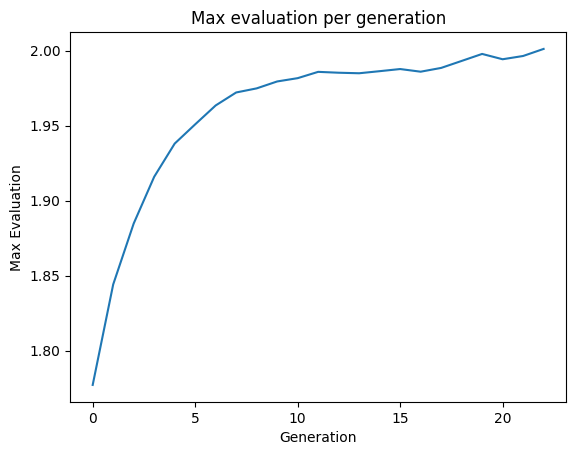

In [12]:
experiment_name = "exp"
experiment_path = "Experiments/"+experiment_name+"/"

if not os.path.exists(experiment_path):
    os.makedirs(experiment_path)

plt.title("Max evaluation per generation")
plt.xlabel("Generation")
plt.ylabel("Max Evaluation")
plt.plot(mean_fit)
plt.savefig(experiment_path+experiment_name+".jpg")

In [13]:
f = open(experiment_path+experiment_name+"_gens.txt","w")
f.write("Mean number of generations: " +str(np.mean(generations)) +"\nMean max evaluation: "+str(max(mean_fit)))
f.close()

In [14]:
best_solution = solutions[max_fits.index(max(max_fits))]
np.savetxt(experiment_path+experiment_name+"_solution.txt", best_solution, delimiter=',')